# Explainable ML Implementation for Healthcare Diagnostics
This notebook demonstrates the application of Explainable ML techniques to predict diabetes using the Pima Indians Diabetes Dataset.

## 1. Introduction
The purpose of this notebook is to implement a Random Forest model to predict diabetes and explain its predictions using SHAP and LIME.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
import math


## 2. Load and Understand Data
Load the Pima Indians Diabetes Dataset and preprocess it.

In [166]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

data = pd.read_csv('C:/Users/User/Documents/Explainable ML/diabetes.csv')

In [167]:
# displaying the first few rows of the dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [168]:
# Information of dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [169]:
# Summary statistics of dataset
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [170]:
# Calculate min, max, and range
min_values = data.min()
max_values = data.max()
range_values = max_values - min_values

# Create a new DataFrame to display the results
summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Range': range_values
})

print(summary_df)


                             Min     Max    Range
Pregnancies                0.000   17.00   17.000
Glucose                    0.000  199.00  199.000
BloodPressure              0.000  122.00  122.000
SkinThickness              0.000   99.00   99.000
Insulin                    0.000  846.00  846.000
BMI                        0.000   67.10   67.100
DiabetesPedigreeFunction   0.078    2.42    2.342
Age                       21.000   81.00   60.000
Outcome                    0.000    1.00    1.000


In [171]:
# Checking for missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [172]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [173]:
# Correlation between the different characteristics. Closer to 1 better is the correlation.

corr_matrix_pearson = data.corr(method='pearson')
corr_matrix_pearson

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


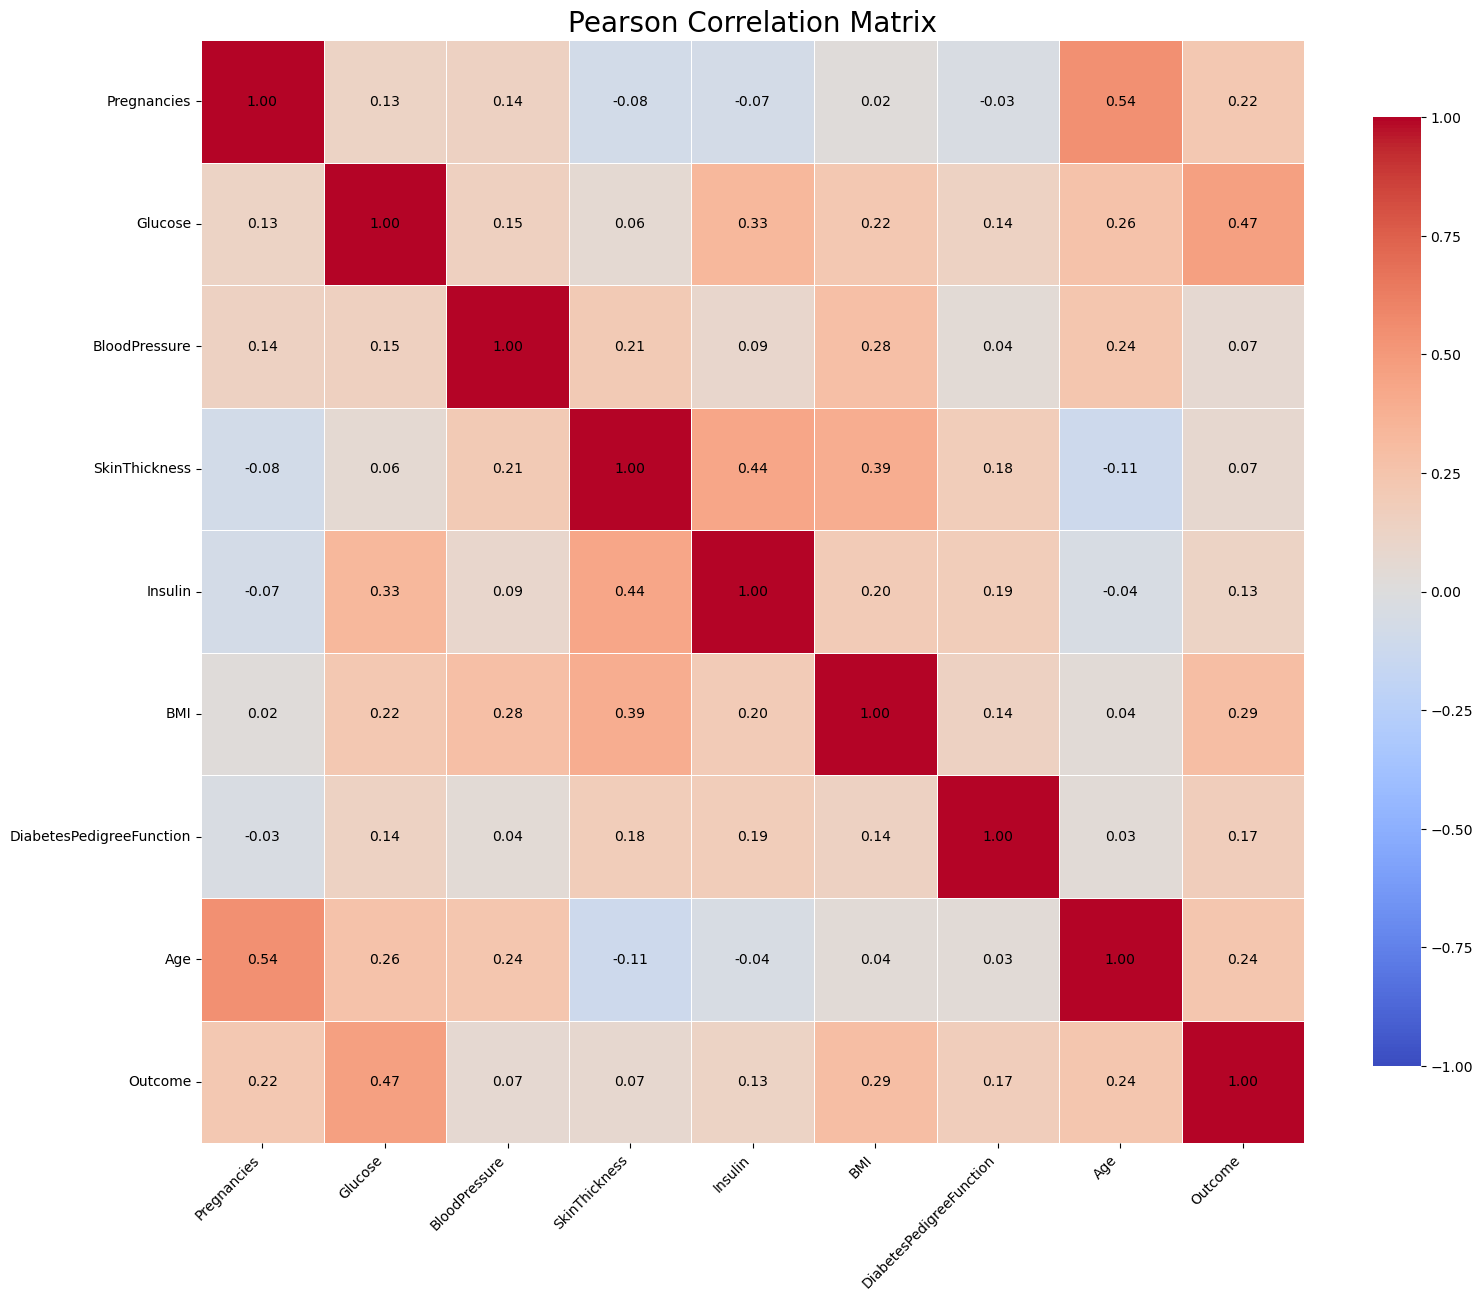

In [174]:
def annotate_heatmap(ax, data, fmt='.2f', **kwargs):
    """
    Annotate the heatmap with text labels.
    """
    data = data.round(2)  # Round the data if needed
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j + 0.5, i + 0.5, format(data.iloc[i, j], fmt),
                    ha='center', va='center', color='black', **kwargs)

plt.figure(figsize=(16, 14))  # Larger figure size for better readability
ax = sns.heatmap(
    corr_matrix_pearson,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .75},
    annot=False  # Disable default annotations
)
annotate_heatmap(ax, corr_matrix_pearson, fmt='.2f')
plt.title('Pearson Correlation Matrix', size=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)               # Rotate y-axis labels if needed
plt.tight_layout()                  # Adjust layout to fit labels
plt.show()


# 2. Splitting, Scaling and Re-sampling

In [175]:
# Feature and target split
X = data.drop("Outcome", axis=1)
y = data["Outcome"]


In [176]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [177]:
# Scaling features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [178]:
y_train.value_counts()

Outcome
0    349
1    188
Name: count, dtype: int64

In [179]:
# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

#Check balancing
y_train_res.value_counts()

Outcome
0    349
1    349
Name: count, dtype: int64

## 3. Hyperparameter Tuning using Bayesian Optimization
Use Bayesian optimization to find the best hyperparameters for the Random Forest model.

In [181]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define parameter search space for Bayesian optimization
param_space = {
    'n_estimators': (10, 1000),
    'max_depth': (1, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'bootstrap': [True, False]
}

# Bayesian hyperparameter tuning
bayes_search = BayesSearchCV(model, param_space, n_iter=32, cv=3, random_state=42, n_jobs=-1)
bayes_search.fit(X_train_scaled_res, y_train_res)

# Best model after tuning
best_model_bayes = bayes_search.best_estimator_

In [182]:
# Predictions
y_pred = best_model_bayes.predict(X_test_scaled)


In [183]:
# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"roc_auc: {f1:.2f}")

Accuracy: 0.74
Precision: 0.76
Recall: 0.74
F1 Score: 0.75
roc_auc: 0.75


## 4. Explainability with SHAP and LIME
Explain the model's predictions.

In [187]:
# Calculate SHAP values
explainer = shap.TreeExplainer(best_model_bayes)
shap_values = explainer.shap_values(X_train_scaled_res)

In [188]:
# Print shap_values
print(shap_values)


[[[ 0.03051476 -0.03051476]
  [ 0.1669567  -0.1669567 ]
  [ 0.01590398 -0.01590398]
  ...
  [ 0.13262837 -0.13262837]
  [ 0.01573413 -0.01573413]
  [ 0.10010505 -0.10010505]]

 [[ 0.01964855 -0.01964855]
  [ 0.15961771 -0.15961771]
  [ 0.00224033 -0.00224033]
  ...
  [-0.03092485  0.03092485]
  [ 0.12546772 -0.12546772]
  [ 0.12879719 -0.12879719]]

 [[-0.01892745  0.01892745]
  [-0.20667625  0.20667625]
  [-0.01112032  0.01112032]
  ...
  [-0.1366107   0.1366107 ]
  [-0.04292008  0.04292008]
  [ 0.07043211 -0.07043211]]

 ...

 [[-0.02802072  0.02802072]
  [ 0.00458923 -0.00458923]
  [-0.04829663  0.04829663]
  ...
  [-0.11916967  0.11916967]
  [-0.04677482  0.04677482]
  [-0.08584004  0.08584004]]

 [[-0.02073178  0.02073178]
  [-0.12322149  0.12322149]
  [-0.00237517  0.00237517]
  ...
  [-0.08252273  0.08252273]
  [-0.04603151  0.04603151]
  [-0.14011545  0.14011545]]

 [[ 0.00958422 -0.00958422]
  [-0.34478508  0.34478508]
  [-0.01460192  0.01460192]
  ...
  [-0.10982531  0.109825

In [190]:
# Verify the shape of SHAP values
print("SHAP values shape:", shap_values.shape)
# Verify the shape of X_train_resampled values
print("X_train_resampled values shape:", X_train_scaled_res.shape)

SHAP values shape: (698, 8, 2)
X_train_resampled values shape: (698, 8)


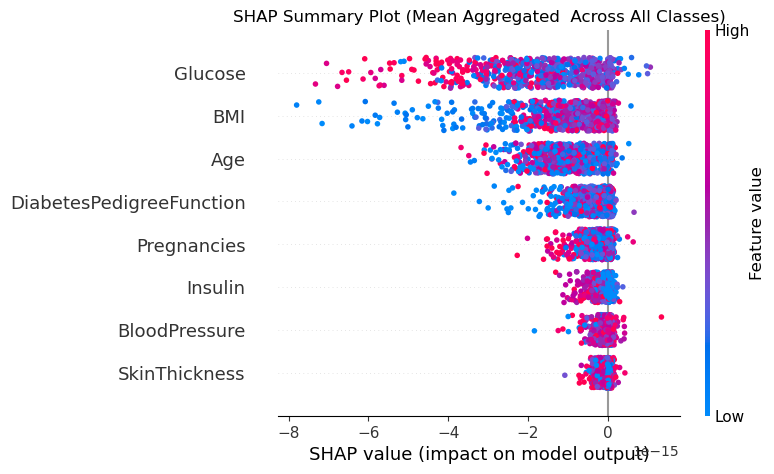

In [207]:
# Sample feature names (replace with your actual feature names)
feature_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

# Assuming X_train_scaled_res is a NumPy array, convert it to a DataFrame with feature names
X_train_scaled_res_df = pd.DataFrame(X_train_scaled_res, columns=feature_names)

# Calculate the mean SHAP values across all classes
mean_shap_values = np.mean(shap_values, axis=2)  # This aggregates across the classes

# Plot the SHAP summary plot for the mean aggregated SHAP values
shap.summary_plot(mean_shap_values, X_train_scaled_res_df, show=False)

# Set the title for the plot
plt.title('SHAP Summary Plot (Mean Aggregated  Across All Classes)')

# Show the plot
plt.show()


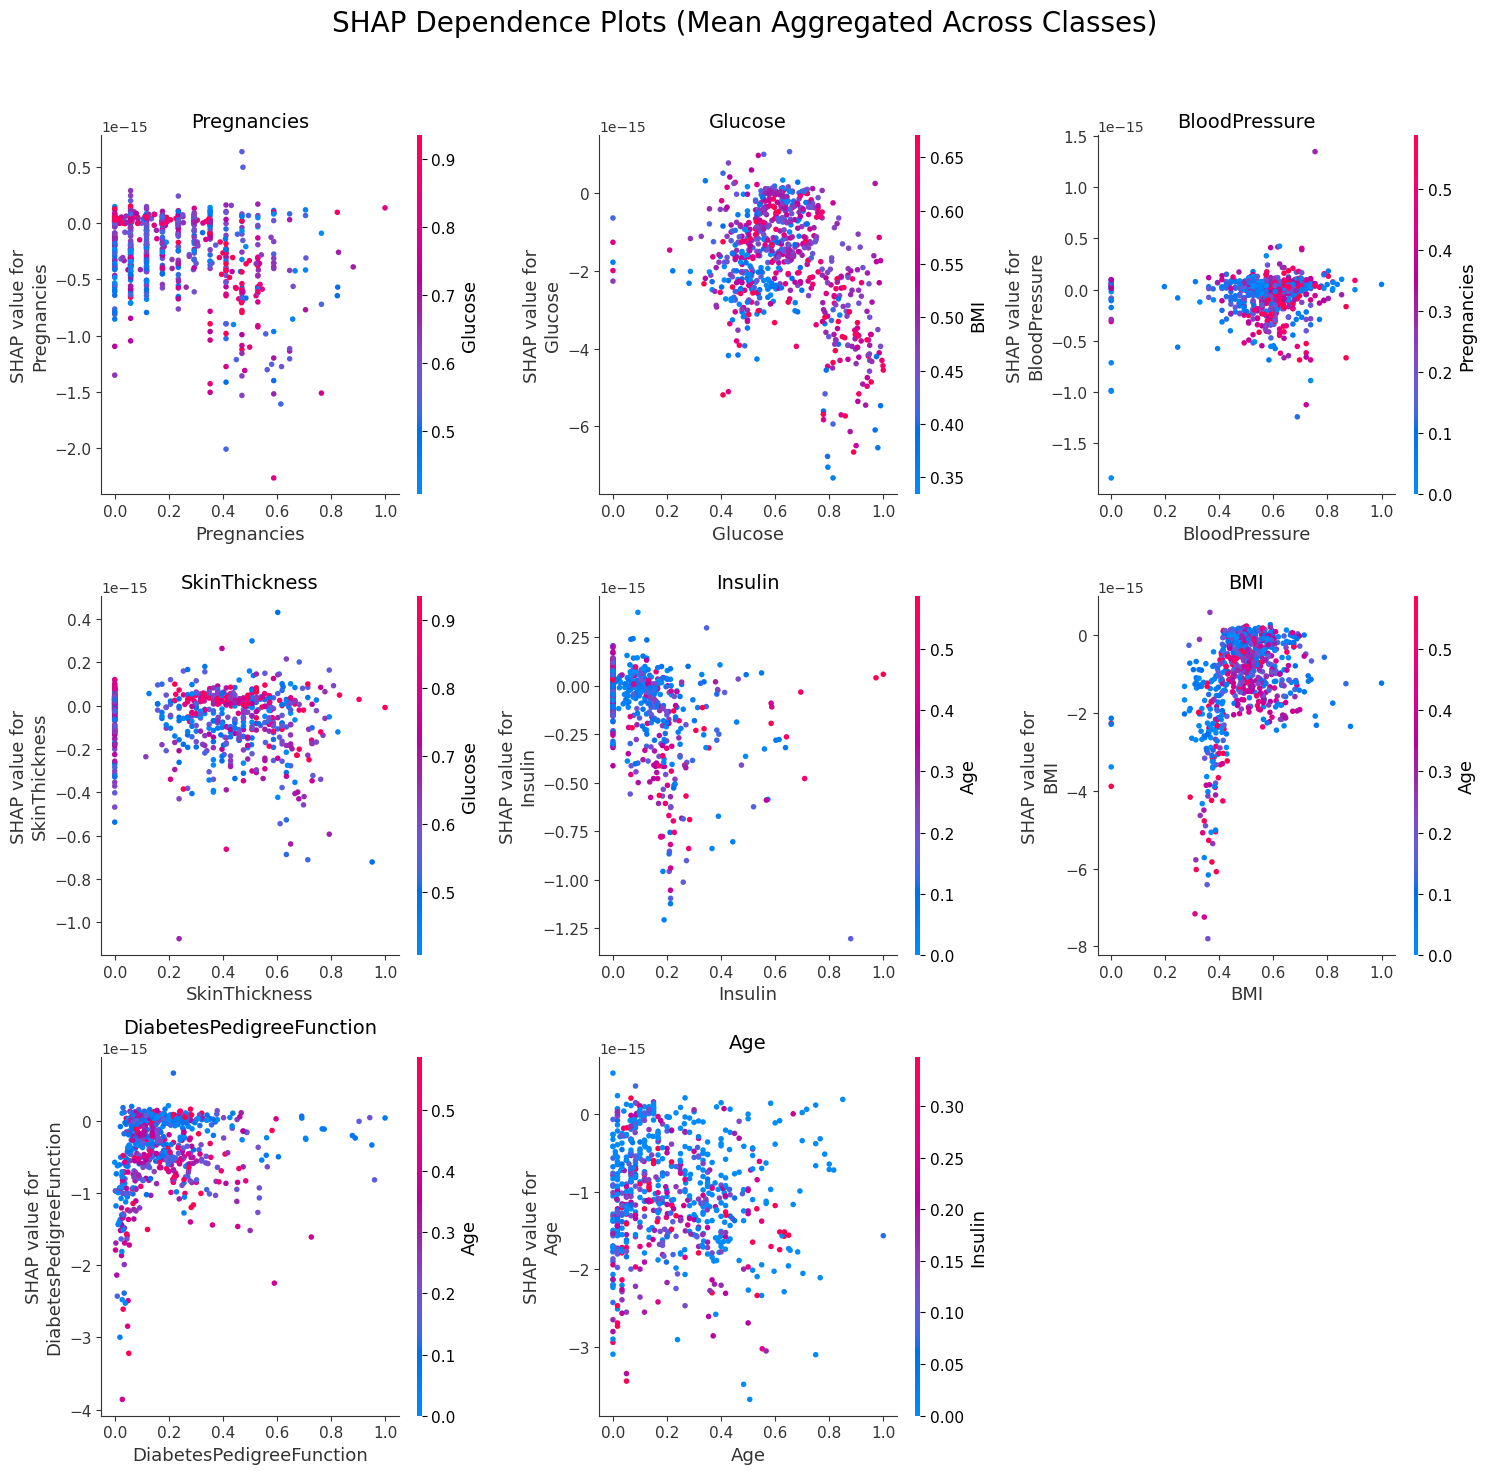

In [209]:
# Set the number of rows and columns for the grid
n_features = len(feature_names)
n_cols = 3  # Adjust the number of columns as needed
n_rows = math.ceil(n_features / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flatten the axes array for easier iteration (even if it's 2D)
axes = axes.flatten()

# Loop through each feature and plot the SHAP dependence plot in the corresponding subplot
for i, feature in enumerate(feature_names):
    ax = axes[i]
    
    # Plot SHAP dependence plot for the current feature using mean SHAP values on the corresponding axis
    shap.dependence_plot(feature, mean_shap_values, X_train_scaled_res_df, ax=ax, show=False)
    
    # Set the title for the subplot
    ax.set_title(f'{feature}', fontsize=14)

# Turn off any empty subplots (in case the number of features is not a perfect multiple of n_cols)
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# Add a main title for the entire grid
fig.suptitle('SHAP Dependence Plots (Mean Aggregated Across Classes)', fontsize=20)

# Adjust the layout so the plots fit neatly
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the entire figure
plt.show()


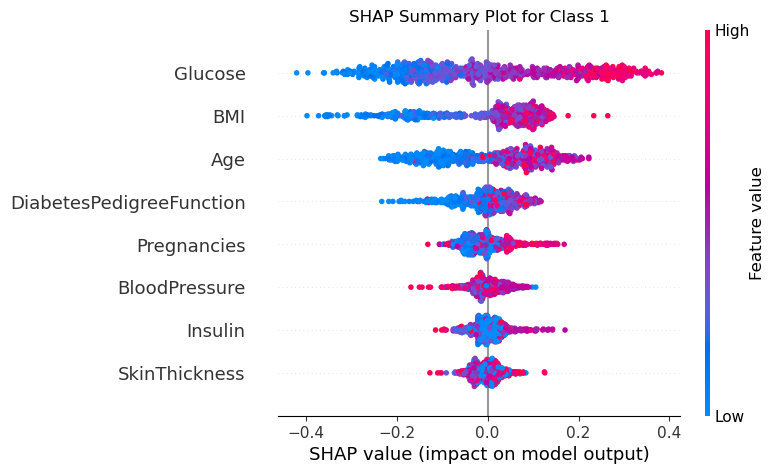

In [195]:
# Sample feature names (replace with your actual feature names)
feature_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'
]

# Assuming X_train_scaled_res is a NumPy array, convert it to a DataFrame with feature names
X_train_scaled_res_df = pd.DataFrame(X_train_scaled_res, columns=feature_names)

# Plot SHAP summary plot for the current class (e.g., Class 0)
shap.summary_plot(shap_values[:, :, 1], X_train_scaled_res_df, show=False)

# Set the title for the plot
plt.title(f'SHAP Summary Plot for Class 1')

# Show the plot
plt.show()


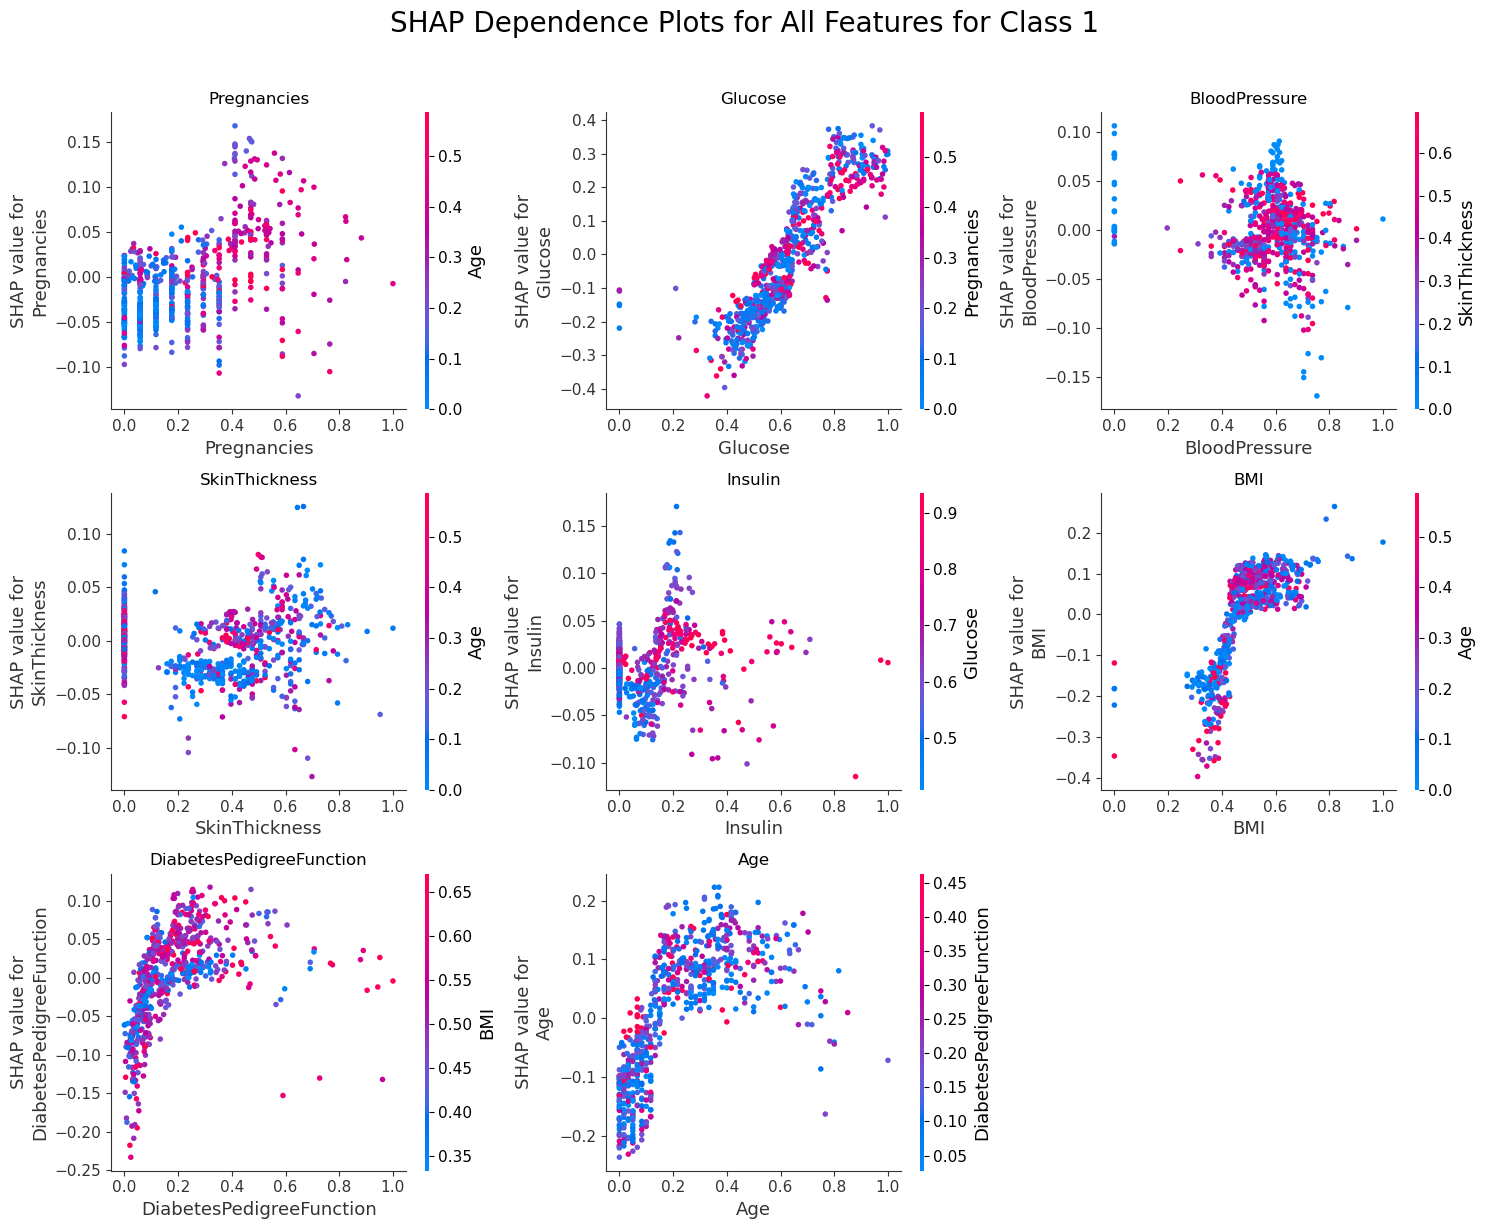

In [205]:
# Determine the number of rows and columns for the grid
n_features = len(feature_names)
n_cols = 3  # Adjust this based on the width of the grid you want
n_rows = math.ceil(n_features / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Set a main title for the entire grid
fig.suptitle('SHAP Dependence Plots for All Features for Class 1', fontsize=20, y=1.02)

# Flatten the axes array for easier iteration (even if it's 2D)
axes = axes.flatten()

# Loop through each feature and plot the SHAP dependence plot in the corresponding subplot
for i, feature in enumerate(feature_names):
    # Select the current axis
    ax = axes[i]
    
    # Plot SHAP dependence plot for the current feature on the corresponding axis
    shap.dependence_plot(feature, shap_values[:, :, 1], X_train_scaled_res_df, ax=ax, show=False)
    
    # Set the title for the subplot
    ax.set_title(f'{feature}', fontsize=12)

# Turn off any empty subplots (in case the number of features is not a perfect multiple of n_cols)
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout so the plots fit neatly
plt.tight_layout()

# Show the entire figure
plt.show()


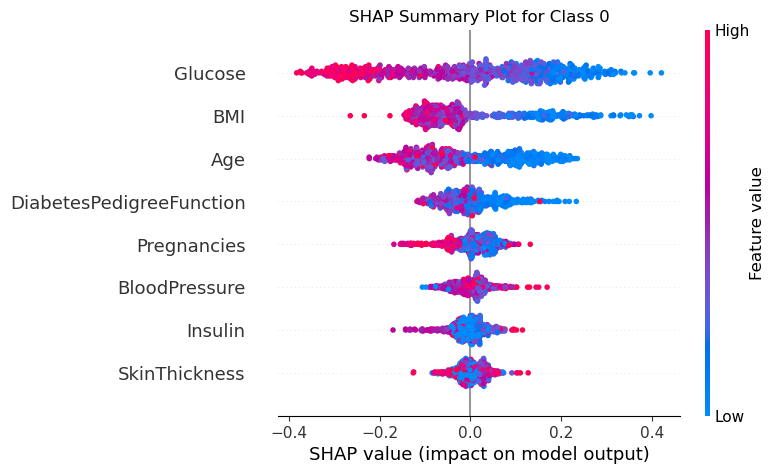

In [196]:
# Plot SHAP summary plot for the current class (e.g., Class 0)
shap.summary_plot(shap_values[:, :, 0], X_train_scaled_res_df, show=False)

# Set the title for the plot
plt.title(f'SHAP Summary Plot for Class 0')

# Show the plot
plt.show()


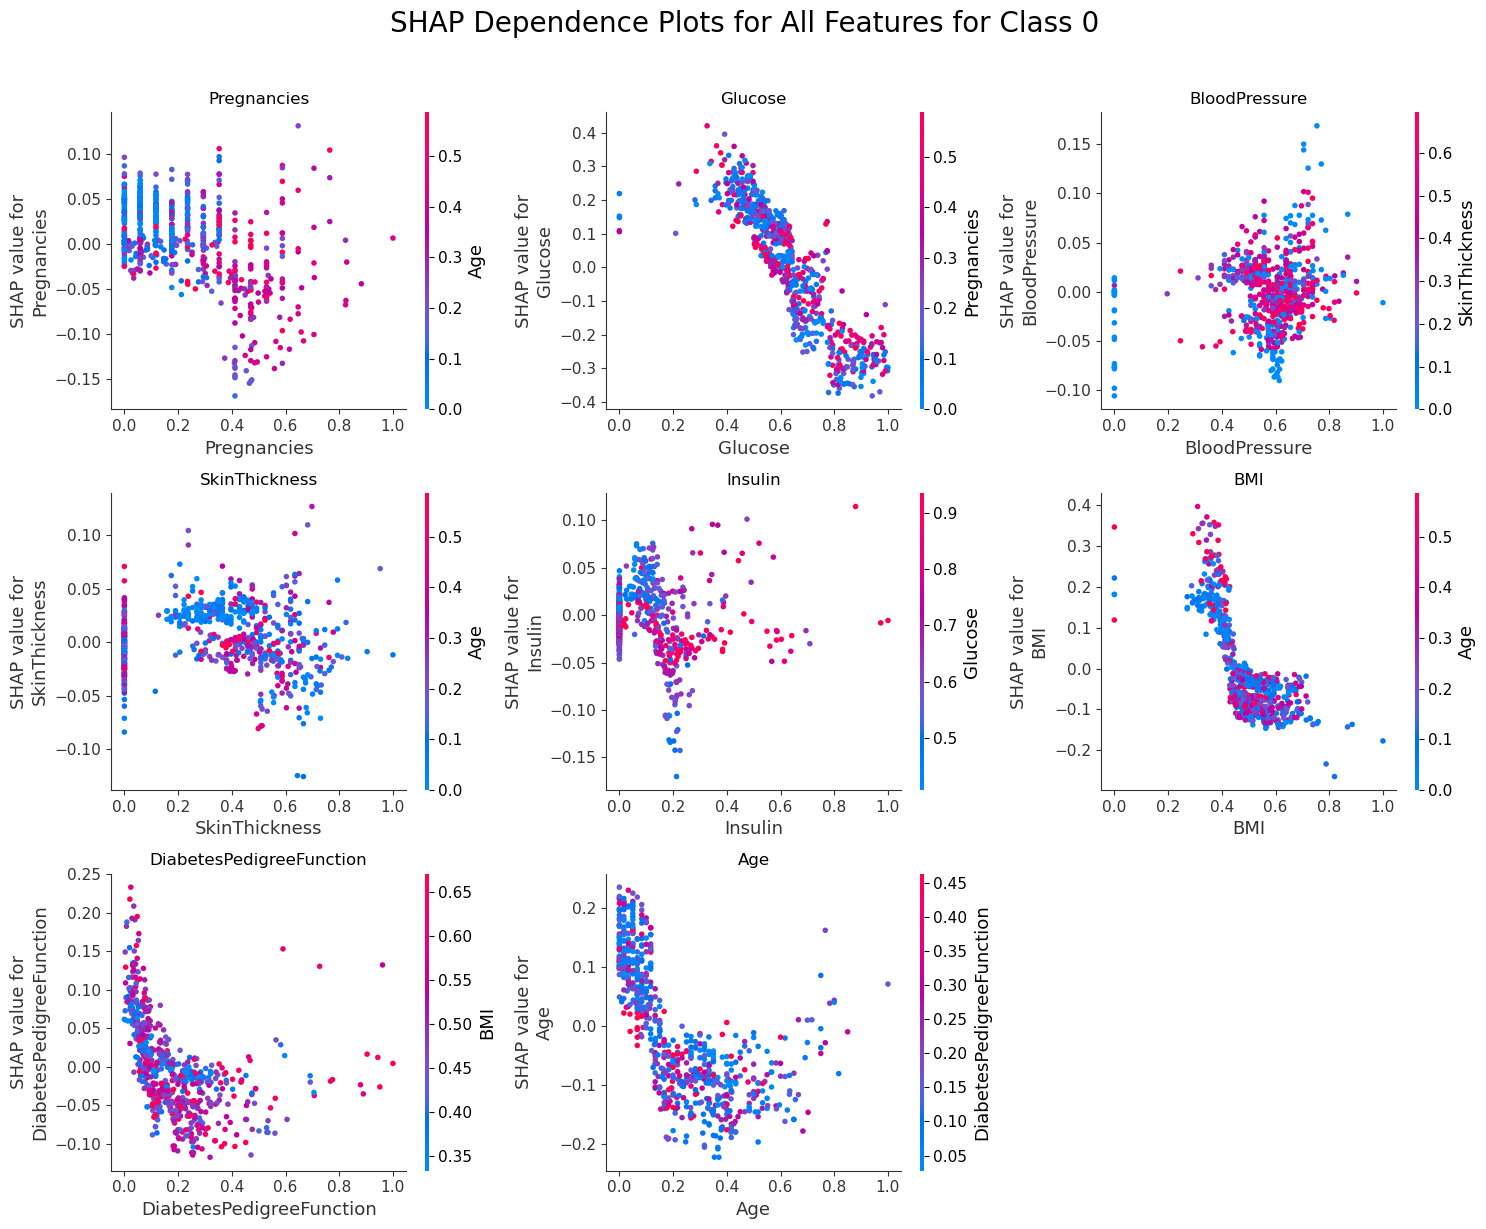

In [204]:
# Determine the number of rows and columns for the grid
n_features = len(feature_names)
n_cols = 3  # Adjust this based on the width of the grid you want
n_rows = math.ceil(n_features / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# Set a main title for the entire grid
fig.suptitle('SHAP Dependence Plots for All Features for Class 0', fontsize=20, y=1.02)

# Flatten the axes array for easier iteration (even if it's 2D)
axes = axes.flatten()

# Loop through each feature and plot the SHAP dependence plot in the corresponding subplot
for i, feature in enumerate(feature_names):
    # Select the current axis
    ax = axes[i]
    
    # Plot SHAP dependence plot for the current feature on the corresponding axis
    shap.dependence_plot(feature, shap_values[:, :, 0], X_train_scaled_res_df, ax=ax, show=False)
    
    # Set the title for the subplot
    ax.set_title(f'{feature}', fontsize=12)

# Turn off any empty subplots (in case the number of features is not a perfect multiple of n_cols)
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout so the plots fit neatly
plt.tight_layout()

# Show the entire figure
plt.show()


In [197]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),         # Training data (as a NumPy array)
    feature_names=X.columns.tolist(),        # Feature names
    class_names=["No Diabetes", "Diabetes"], # Class names
    discretize_continuous=True               # Whether to discretize continuous features
)

# Index of the sample to explain
i = 10  # You can change this index to explain other predictions

# Explain a single prediction
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,              # Instance to explain (from test set)
    predict_fn=best_model_bayes.predict_proba,   # Prediction function (probabilities)
    num_features=7                               # Number of features to display
)

# Show the explanation in a readable format
lime_exp.show_in_notebook(show_table=True)


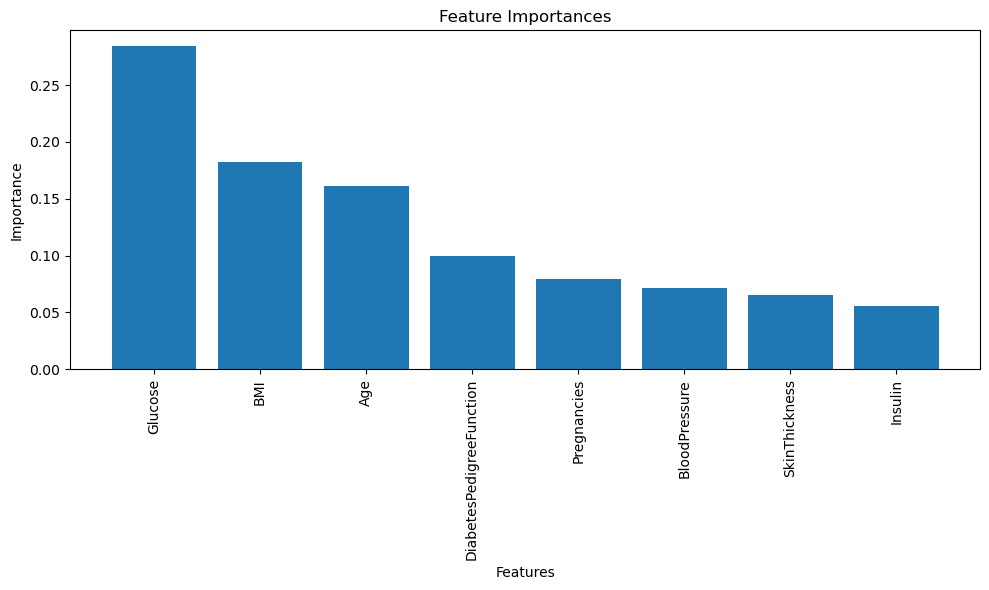

In [198]:
# Get feature importances from the model
importances = best_model_bayes.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


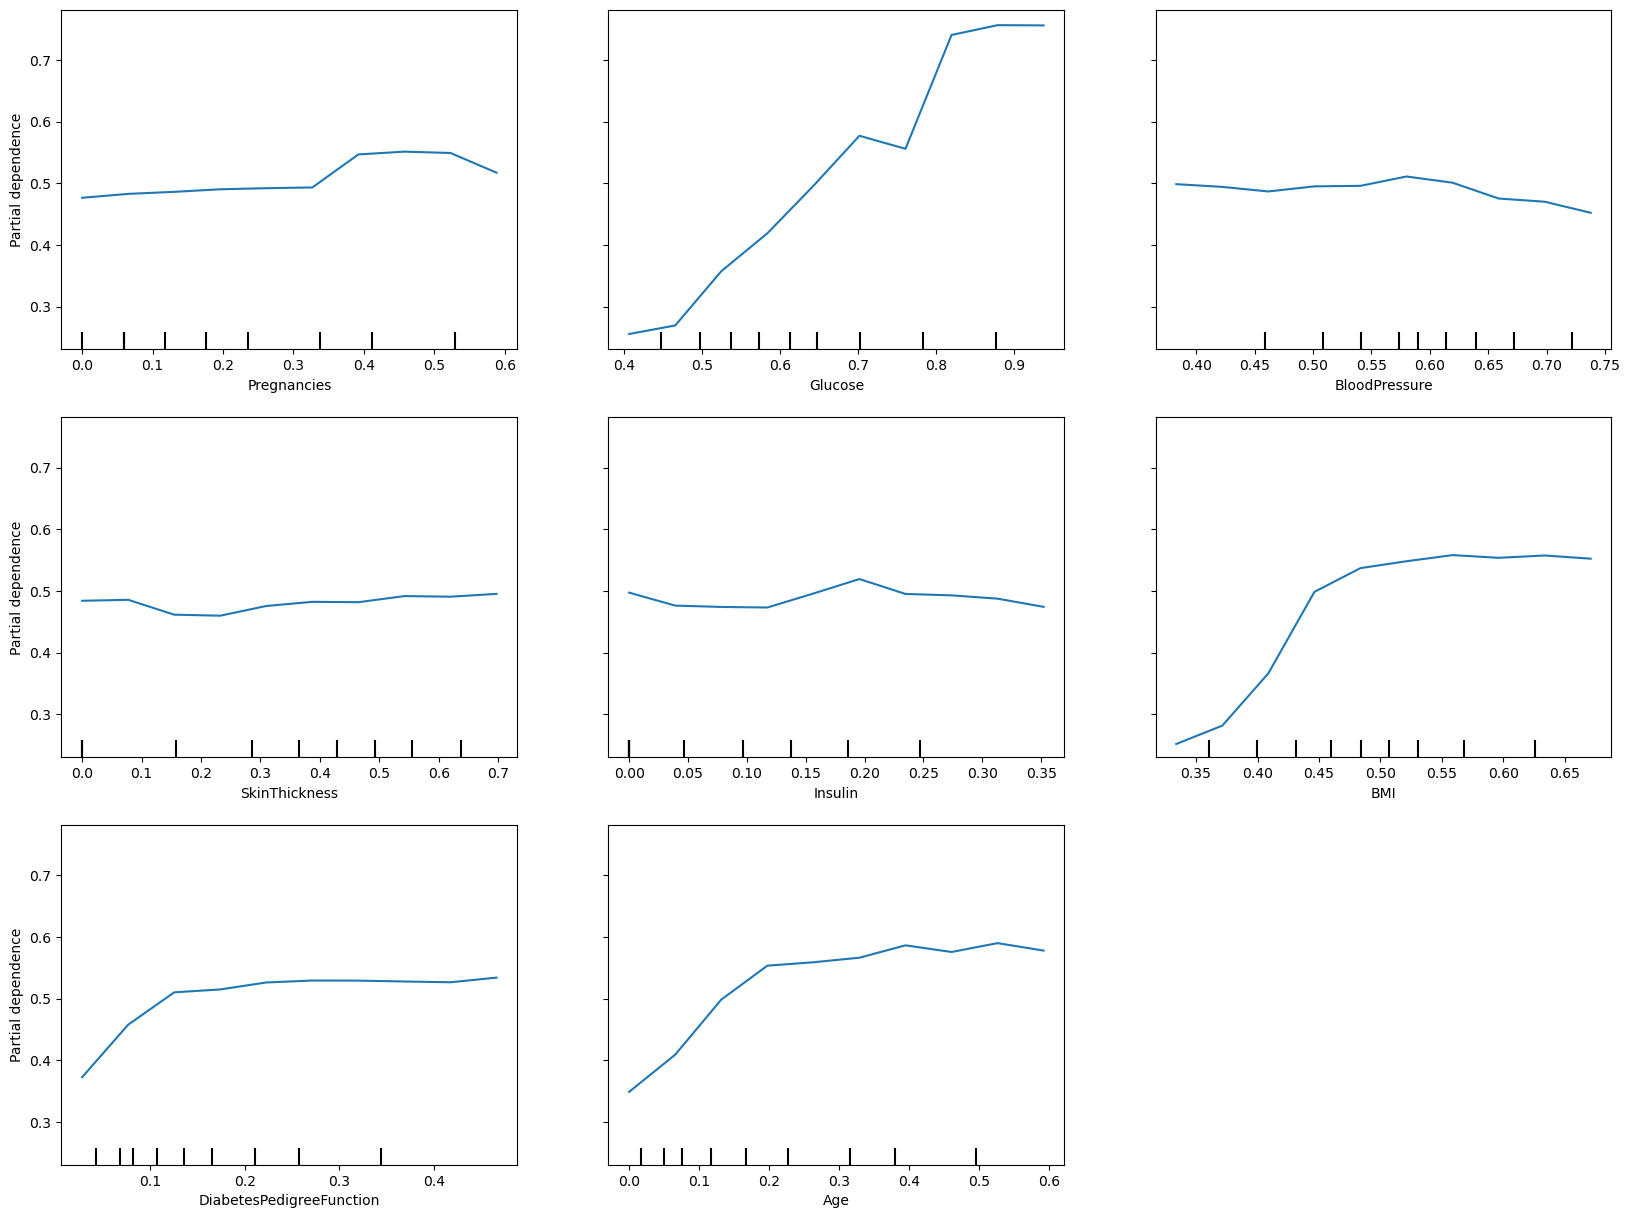

In [201]:
# Define the features to plot
features = list(range(X_train_scaled_res.shape[1]))  # Create a list of all feature indices

# Set up the figure with a larger size to accommodate all plots and labels
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the Partial Dependence Plots with adjusted layout
display = PartialDependenceDisplay.from_estimator(
    best_model_bayes,           # Your trained model
    X_train_scaled_res,         # Scaled training data
    features,                   # Features to plot
    feature_names=X.columns,    # Feature names
    grid_resolution=10,         # Resolution of the grid (more points = more detail)
    ax=ax                       # Use the ax to control layout
)

# Show the plots
plt.show()
